# Step 0 - Setting up libraries.

In [1]:
import fastf1 as f1
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fastf1 import plotting

f1.Cache.enable_cache('f1_cache')
plotting.setup_mpl()

# Step 1. Utility - Team colour helper setup.

In [20]:
def _team_colour(team_name: str, session, colormap: str = 'official') -> str:
    # Returning FastF1's colours for a team. If team not found, return grey.
    try:
        canonical = plotting.get_team_name(team_name, session=session)
        return plotting.get_team_color(canonical, session=session, colormap=colormap)
    except Exception:
        return "#808080"  # Grey color for unknown teams

# Step 2. Collecting Season Points [Drivers and Constructors]

In [24]:
def get_season_points(year: int = 2024, include_sprints: bool = False):
    # Gathering season results for all rounds in a year. 

    schedule_df = f1.get_event_schedule(year).sort_values('RoundNumber')
    rounds = schedule_df['RoundNumber'].tolist()

    all_rows = []

    for round_num in rounds:
        event = schedule_df.loc[schedule_df['RoundNumber'] == round_num].iloc[0]
        event_name = event['EventName']
        event_format = str(event.get('EventFormat', '')).lower()
        
        # Collecting sessions that award points.
        session_types = ['R'] # Race always awards points.

        # Checking for sprint sessions in events that have them. 
        if include_sprints and 'sprint' in event_format:
            session_types.append('S')

        for session_type in session_types:
            try:
                # Loading the sessions and reading the results table.
                s = f1.get_session(year, round_num, session_type)
                s.load()
                df = s.results[['Abbreviation', 'DriverNumber', 'TeamName', 'Points']].copy()
                
                # Annotating with the metadata for easier identification, later grouping and plotting. 
                df['RoundNumber'] = round_num
                df['EventName'] = event_name
                df['SessionType'] = session_type
                df['TeamColor'] = df['TeamName'].apply(lambda tn: _team_colour(tn, s))
                all_rows.append(df)
            except Exception as e:
                print(f"[warning] Could not load {year} Round {round_num} Session {session_type} ({event_name}) : {e}")
        
    if not all_rows:
        raise RuntimeError("No data collected. Check year or network access.")
        
    results = pd.concat(all_rows, ignore_index=True)

    drivers_round = (
        results
        .groupby(['Abbreviation', 'RoundNumber', 'EventName', 'TeamColor'], as_index=False)
        .agg(
            Points = ('Points', 'sum'),
            TeamName = ('TeamName', lambda x: x.mode().iat[0] if len(x.mode()) else x.iloc[0])
        )
    )

    constructors_round = (
        results
        .groupby(['TeamName', 'RoundNumber', 'EventName', 'TeamColor'], as_index=False)
        .agg(
            Points = ('Points', 'sum')
        )
    )

    x_labels = (
        schedule_df[['RoundNumber', 'EventName']]
        .drop_duplicates()
        .sort_values('RoundNumber')
        .reset_index(drop=True)
    )

    return drivers_round, constructors_round, x_labels 

# Step 3. Building the cumulative tables.

In [25]:
def make_cumulative_tables(drivers_round: pd.DataFrame, constructors_round: pd.DataFrame):
    # Adding cumulative points for drivers and constructors.

    d = drivers_round.sort_values(['Abbreviation', 'RoundNumber']).copy()
    d['CumulativePoints'] = d.groupby('Abbreviation')['Points'].cumsum()

    c = constructors_round.sort_values(['TeamName', 'RoundNumber']).copy()
    c['CumulativePoints'] = c.groupby('TeamName')['Points'].cumsum()

    return d, c

# Step 4. Plotting the Drivers Cumulative Points [Team Coloured] with optional Top-N selection.

In [27]:
def plot_driver_cumulative(drivers_cumulative: pd.DataFrame, x_labels: pd.DataFrame, color_by_team: bool = True, only_top_n: int | None = None, figsize=(14,12)):
        final_totals = drivers_cumulative.sort_values('RoundNumber').groupby('Abbreviation', as_index=False).tail(1)
        if only_top_n:
                keep_drivers = (
                        final_totals
                        .sort_values('CumulativePoints', ascending=False)
                        .head(only_top_n)['Abbreviation']
                )
                drivers_cumulative = drivers_cumulative[drivers_cumulative['Abbreviation'].isin(keep_drivers)]

        # Mapping Driver -> Team Colour based on most frequent teams across the season.
        if color_by_team:
                driver_team = (
                        drivers_cumulative.groupby('Abbreviation')['TeamColor']
                        .agg(lambda x: x.mode().iat[0] if len(x.mode()) else x.iloc[0])
                )
                color_map = {
                        drv: color for drv, color in driver_team.items()
                }
        else:
                color_map = {} # Default matplotlib colours.
        
        plt.figure(figsize=figsize)
        for drv, grp in drivers_cumulative.groupby('Abbreviation', sort=False):
                color = color_map.get(drv, None)
                plt.plot(
                        grp['RoundNumber'],
                        grp['CumulativePoints'],
                        label=drv,
                        color=color,
                        linewidth=2
                )

        rounds = x_labels['RoundNumber'].tolist()
        event_names = x_labels['EventName'].tolist()
        plt.xticks(ticks=rounds, labels=event_names, rotation=60, ha='right')

        plt.xlabel('Grand Prix Event')
        plt.ylabel('Drivers Standings')
        plt.title('2024 F1 Drivers Standings Progression')
        plt.grid(True, alpha=0.3)
        plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', ncol=1, title='Driver')
        plt.tight_layout()
        plt.show()



# Step 5. Plotting the Constructors Cumulative Points.

In [41]:
def plot_constructor_cumulative(constructors_cumulative: pd.DataFrame, x_labels: pd.DataFrame, figsize=(14,10)):
    # Plotting the Constructors Cumulative Points with race names on X-axis. 
    plt.figure(figsize=figsize)
    for team, grp in constructors_cumulative.groupby('TeamName', sort=False):
        plt.plot(
            grp['RoundNumber'],
            grp['CumulativePoints'],
            label=team,
            linewidth=2,
            color=grp['TeamColor'].iloc[0]
        )
    rounds = x_labels['RoundNumber'].tolist()
    event_names = x_labels['EventName'].tolist()
    plt.xticks(ticks=rounds, labels=event_names, rotation=60, ha='right')
    
    plt.xlabel('Grand Prix Event')
    plt.ylabel('Constructors Cumulative Points')
    plt.title('2024 F1 Constructors Standings Progression')
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', ncol=1, title='Team')
    plt.tight_layout()
    plt.show()

# Step 6. Loading the sessions and gathering all the data.

In [44]:
drivers_round, constructors_round, x_labels = get_season_points(year=2024, include_sprints=False)
drivers_cumulative, constructors_cumulative = make_cumulative_tables(drivers_round, constructors_round)

core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


[warning] Could not load 2024 Round 0 Session R (Pre-Season Testing) : Cannot get testing event by round number!


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '63', '4', '44', '81', '14', '18', '24', '20', '3', '22', '23', '27', '31', '10', '77', '2']
core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req 

# Step 7. Running all the pipelines (Race-only Points).

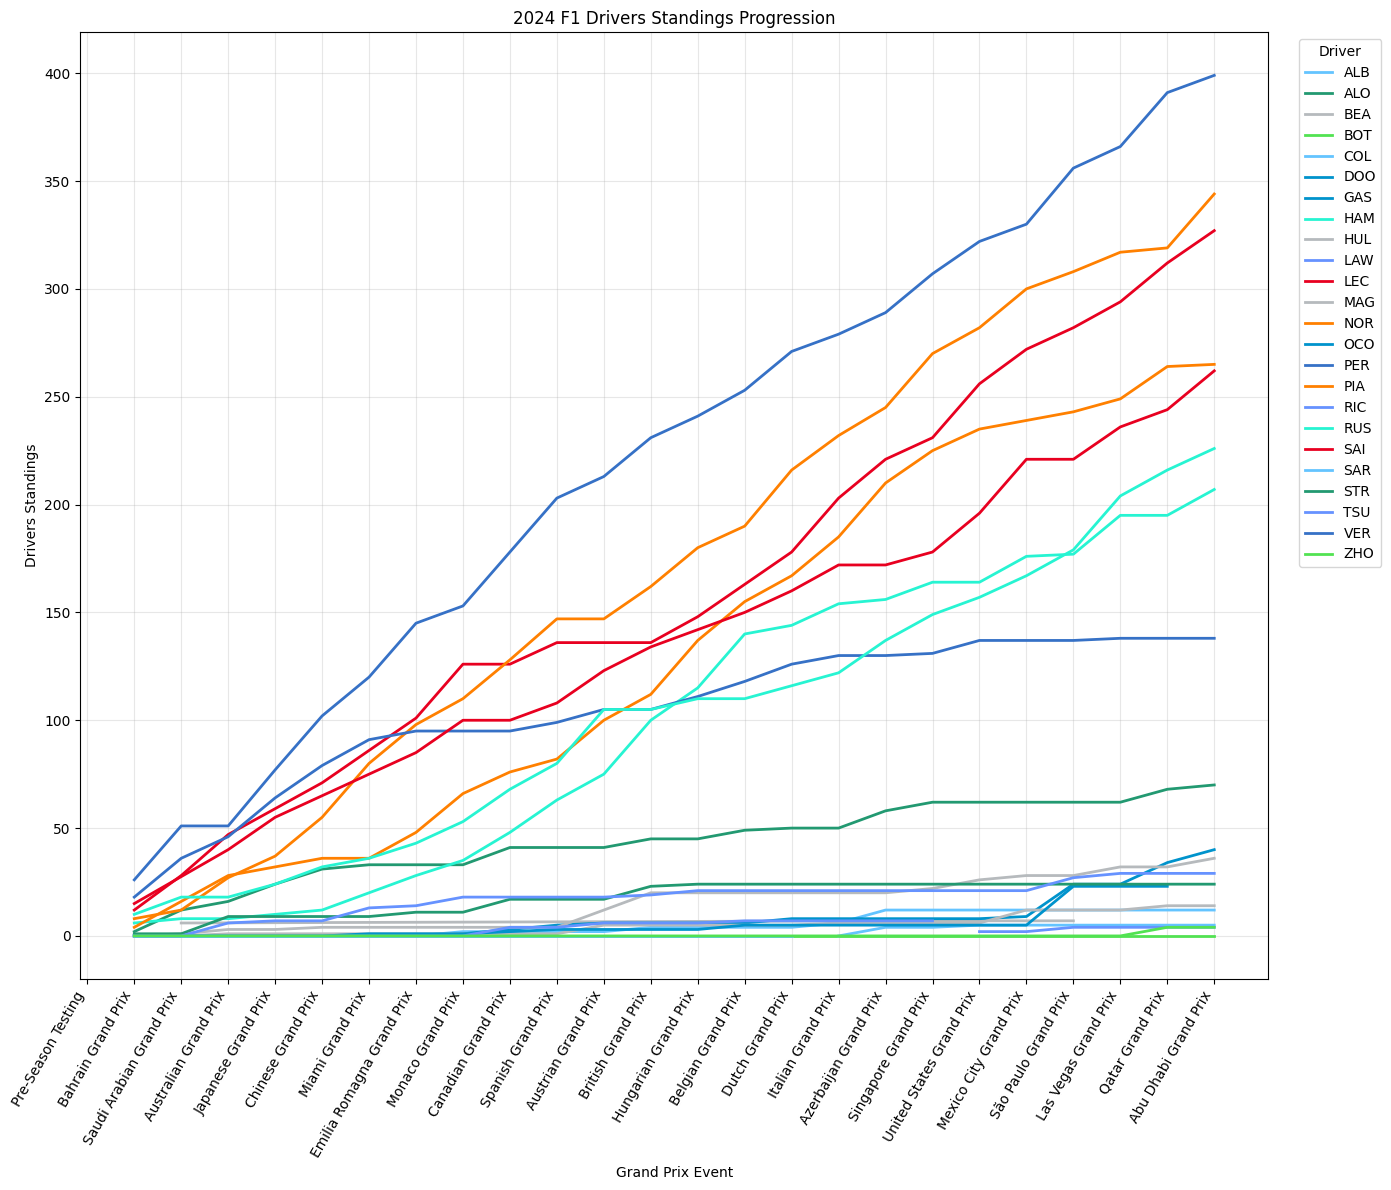

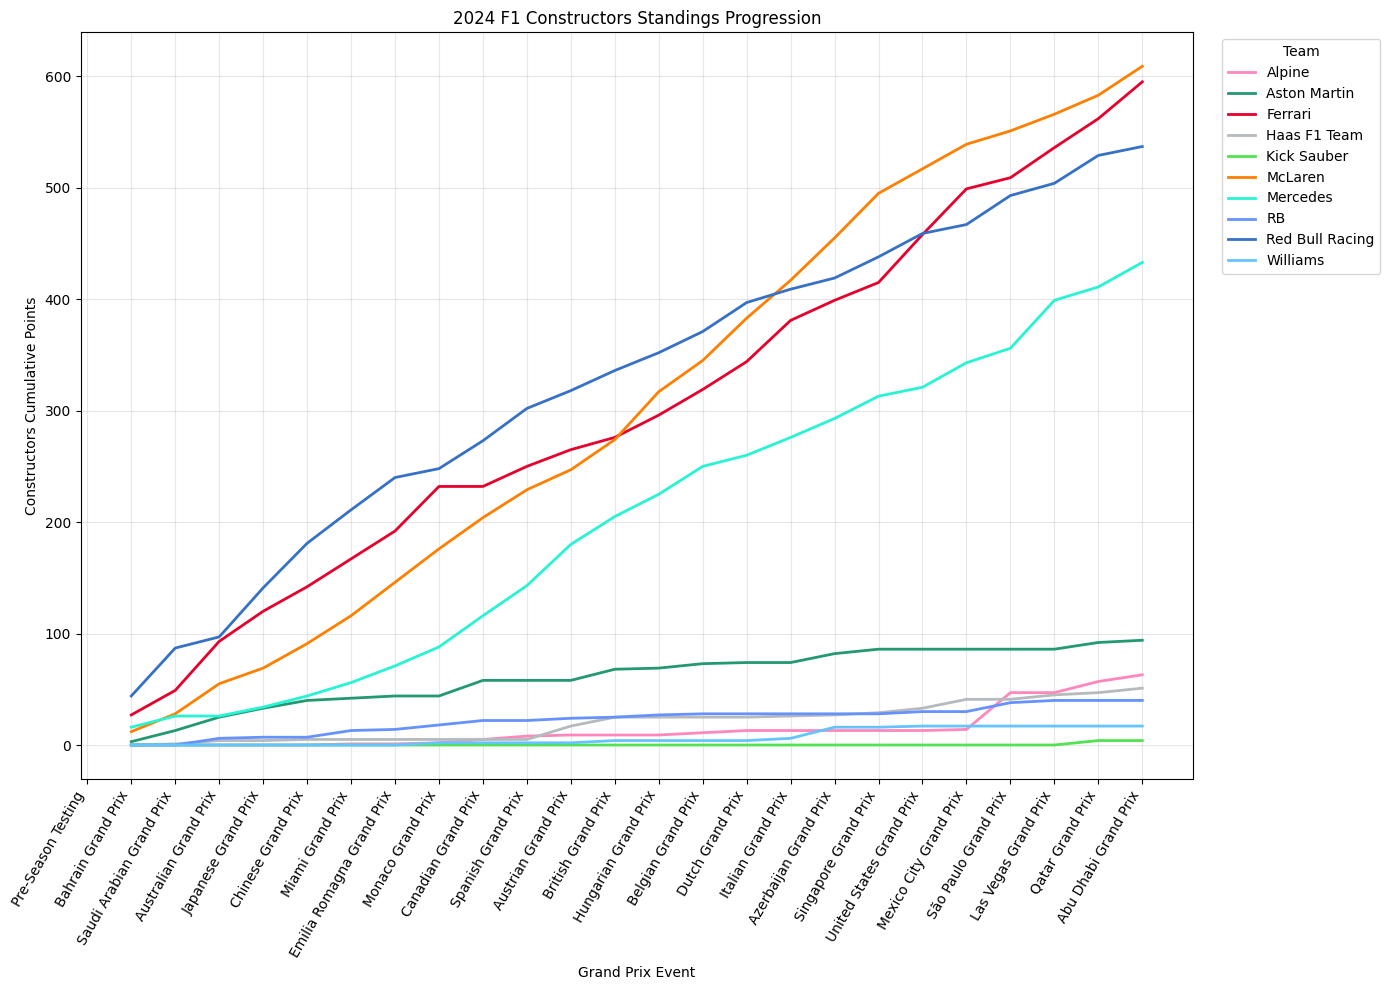

In [48]:
# Drivers: Show everything with team colored lines.
plot_driver_cumulative(drivers_cumulative, x_labels, color_by_team=True)

# Constructors: Cumulative Progression.
plot_constructor_cumulative(constructors_cumulative, x_labels)

# Step 8. (Optional) Including sprints points in totals.

In [49]:
drivers_round_s, constructors_round_s, x_labels_s = get_season_points(2024, include_sprints=True)

core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


[warning] Could not load 2024 Round 0 Session R (Pre-Season Testing) : Cannot get testing event by round number!


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '63', '4', '44', '81', '14', '18', '24', '20', '3', '22', '23', '27', '31', '10', '77', '2']
core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req 

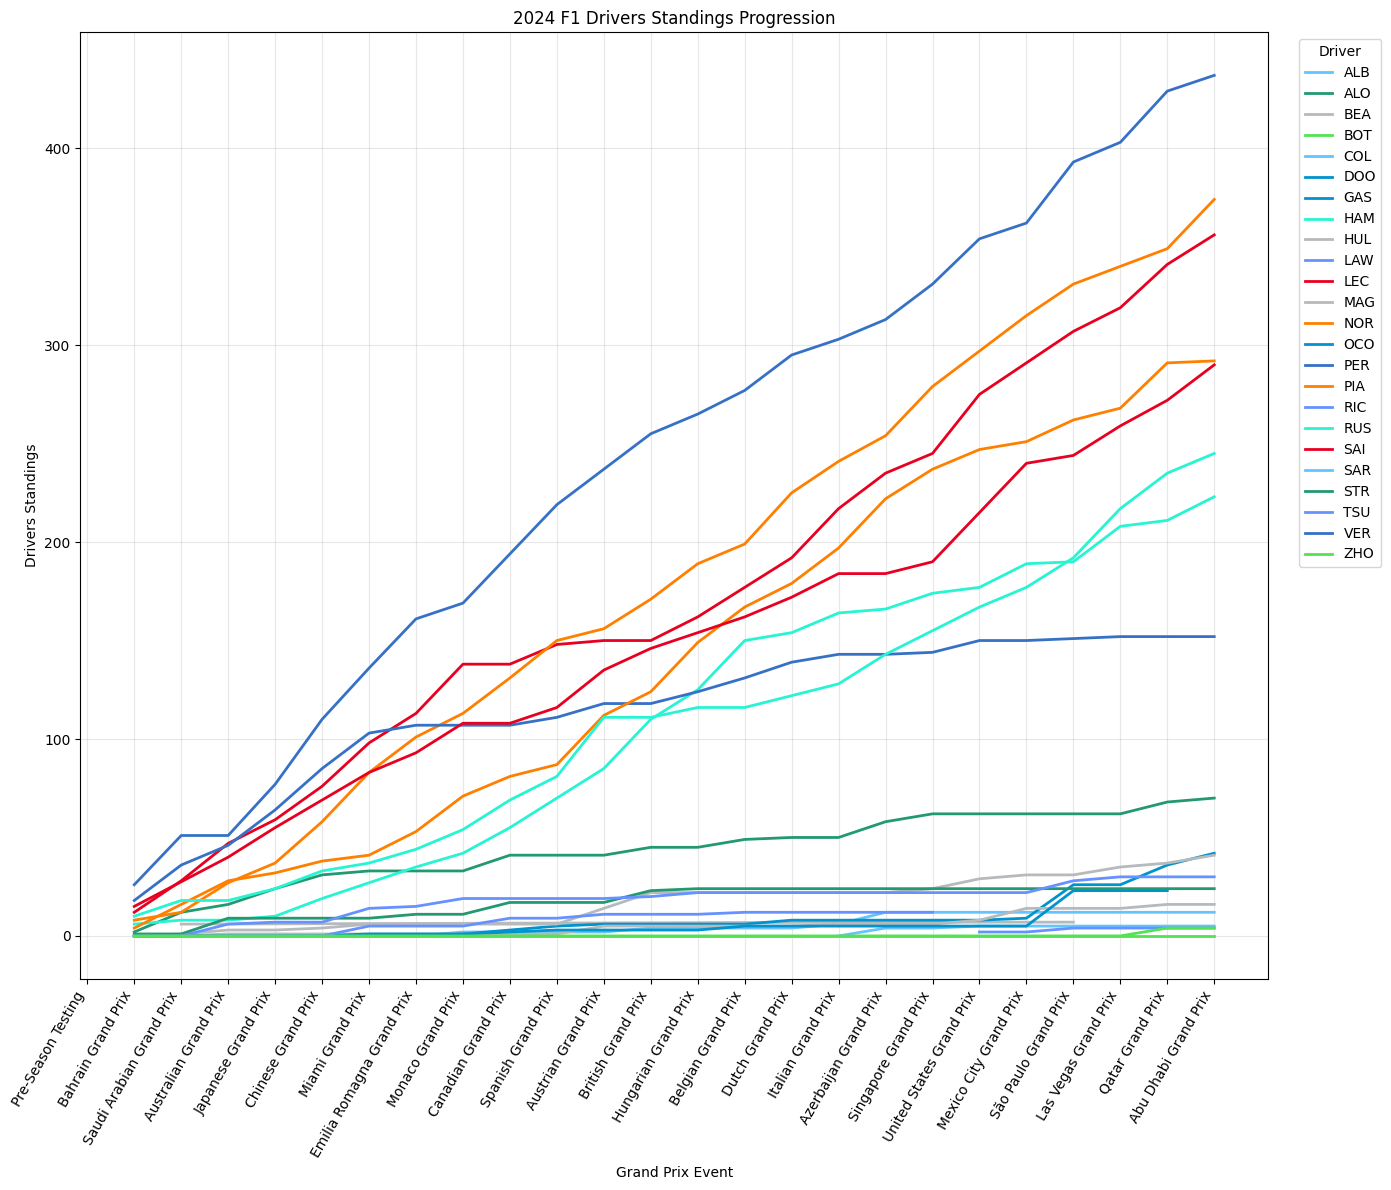

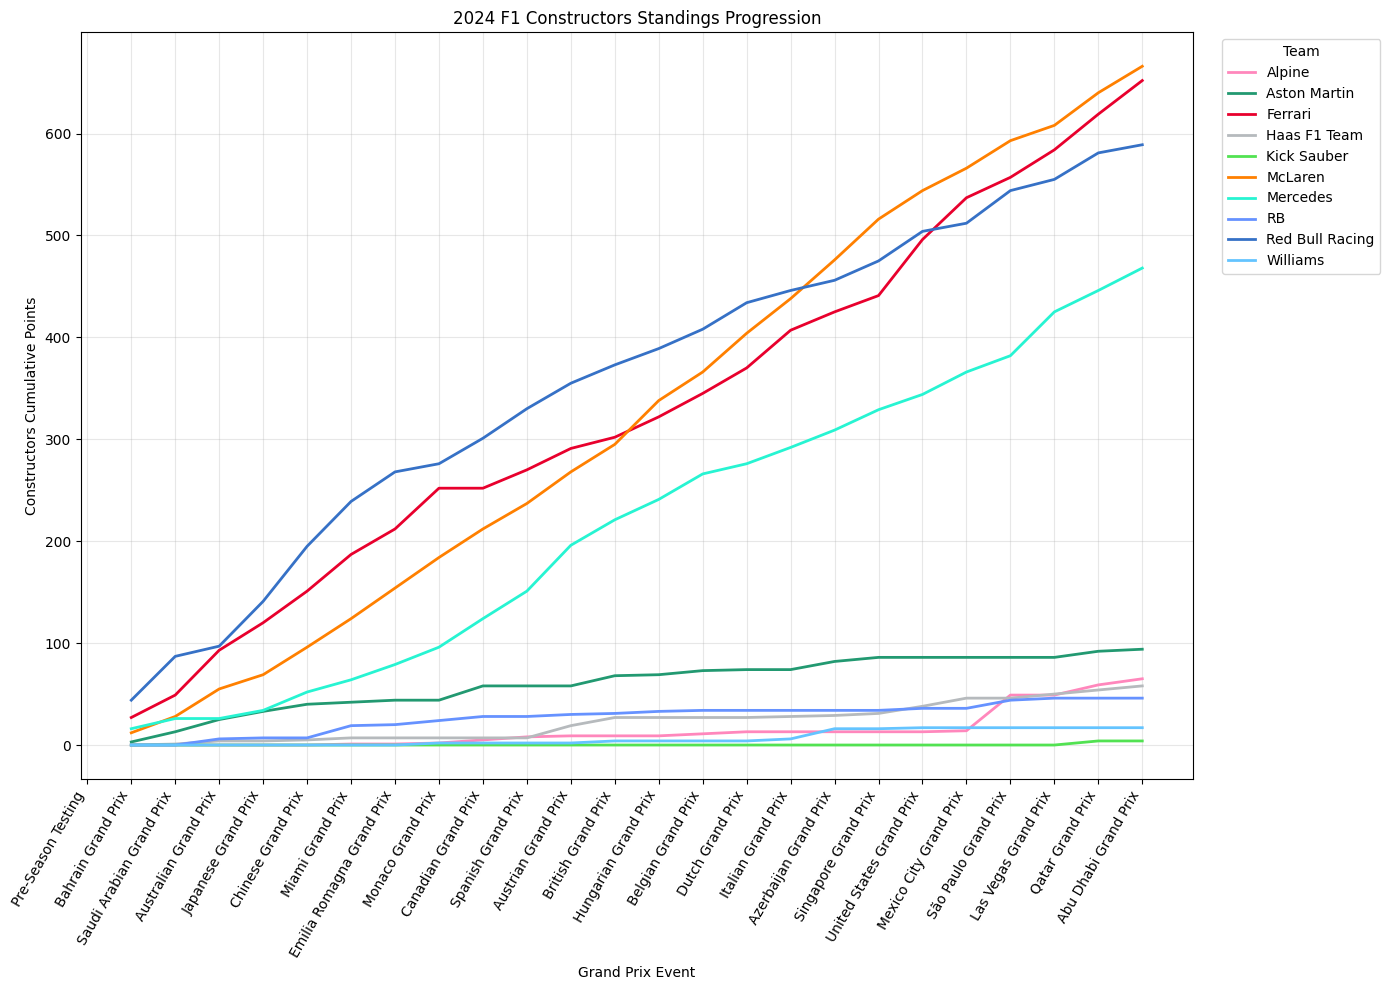

In [51]:
d_cum_s, c_cum_s = make_cumulative_tables(drivers_round_s, constructors_round_s)

plot_driver_cumulative(d_cum_s, x_labels_s, color_by_team=True)
plot_constructor_cumulative(c_cum_s, x_labels_s)

# Step 9. (Optional) Adding and interactive plotly line chart.

In [ ]:
import plotly.express as px

def plot_driver_cumulative_plotly(d_cum: pd.DataFrame):

    # Determining a stable team label for each driver.
    driver_team = (
        d_cum.groupby('Abbreviation')['TeamName']
        .agg(lambda x: x.mode().iat[0] if len(x.mode()) else x.iloc[0])
    )

    d_plot = d_cum.merge(
        driver_team.rename('Team'),
        left_on='Abbreviation',
        right_index=True,
        how='left'
    )

    fig = px.line(
        d_plot,
        x = 'RoundNumber',
        y = 'CumulativePoints',
        color = 'Team',
        line_group = 'Abbreviation', 
        hover_data = ('Abbreviation', 'TeamName', 'EventName', 'Points', 'CumulativePoints'),
        labels = {'RoundNumber': 'Round', 'CumulativePoints': 'Cumulative Points'},
        title = '2024 F1 Drivers Standings Progression (Plotly Interactive)'
    )

    # Replacing Round Numbers with GP Names on X-axis.
    x_lbls = (
        d_cum[['RoundNumber', 'EventName']]
        .drop_duplicates()
        .sort_values('RoundNumber')
    )

    fig.update_xaxes(
        tickmode='array',
        tickvals=x_lbls['RoundNumber'].tolist(),
        ticktext=x_lbls['EventName'].tolist(),
        tickangle=60
    )

    fig.update_layout(
        legend_title_text='Driver',
        hovermode='x unified'
    )

    return fig

fig = plot_driver_cumulative_plotly(drivers_cumulative)
fig.show()